
<h1 style="text-align:center;">Airline Twitter Sentiment Analysis</h1>

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import unicodedata

# emoji library
from emoji import unicode_codes
emojis = unicode_codes.get_emoji_unicode_dict(lang='en')
import nltk
from nltk.corpus import stopwords
from string import punctuation
import contractions
STOPWORDS = set(stopwords.words('english'))

# SpellChecker
from spellchecker import SpellChecker
spell = SpellChecker()

# Textblob
from textblob import Word

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# webscrap for airport IATA codes - Use Selenium for that purpose
from selenium import webdriver   # for webdriver
from selenium.webdriver.support.ui import WebDriverWait  # for implicit and explict waits
from selenium.webdriver.chrome.options import Options  # for suppressing the browser

# set the driver
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')
driver = webdriver.Chrome(options=options)

# Beautiful Soup
from bs4 import BeautifulSoup

#regex
import re

import chardet

In [21]:
!pwd

/home/salvado/Desktop/github/DataScience_portfolio/Airlines Twitter Sentiment Analysis


In [2]:
data_dir = "/home/salvado/Documents/TensorFlow/Pratice/Twitter Sentiment Analysis"
os.listdir(data_dir)

['Twitter Sentiment Analysis.ipynb',
 'Airline-Sentiment-2-w-AA.csv',
 '.ipynb_checkpoints']

In [3]:
airline_reviews = pd.read_csv("Airline-Sentiment-2-w-AA.csv", encoding='ISO-8859-1')
airline_reviews.head(2)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)


In [4]:
airline_reviews['negativereason']

0                           NaN
1                           NaN
2                           NaN
3                    Bad Flight
4                    Can't Tell
                  ...          
14635                       NaN
14636    Customer Service Issue
14637                       NaN
14638    Customer Service Issue
14639                       NaN
Name: negativereason, Length: 14640, dtype: object

In [113]:
airline_reviews.shape

(14640, 20)

<p>Let's separate and define our feature and target</p>

In [114]:
# remove suplicates
airline_reviews.drop_duplicates(inplace=True)
airline_reviews.shape

(14640, 20)

In [115]:
all_columns = airline_reviews
features = ['text', 'airline', 'airline_sentiment']
for column in all_columns:
    if column not in features:
        airline_reviews.drop(column, axis=1, inplace=True)
        
airline_reviews.columns

Index(['airline_sentiment', 'airline', 'text'], dtype='object')

<h4>Checking for null values</h4>

In [116]:

airline_reviews['airline_sentiment'].isna().sum(), airline_reviews['airline'].isna().sum(), airline_reviews['text'].isna().sum()

(0, 0, 0)

<h3>EDA on the data that we'll use.</h3>

In [117]:
airline = airline_reviews['airline'].unique()
airline

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

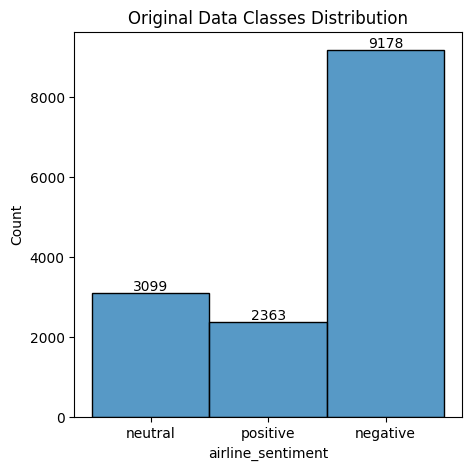

In [118]:
plt.figure(figsize=(5,5))
ax = sns.histplot(data=airline_reviews, x= airline_reviews['airline_sentiment'])
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Original Data Classes Distribution')
plt.show()

<p>As was expected the amount of negative reviews is far greater than the neutral and positive combined.</p>
<p>We have to take care of these imbalenced classes but will do after text pre-processing</p>

<p>Let's take a look at the text to see what we have to do.</p>

In [30]:
airline_reviews['text'][0:10]

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
5    @VirginAmerica seriously would pay $30 a fligh...
6    @VirginAmerica yes, nearly every time I fly VX...
7    @VirginAmerica Really missed a prime opportuni...
8    @virginamerica Well, I didn'tÛ_but NOW I DO! :-D
9    @VirginAmerica it was amazing, and arrived an ...
Name: text, dtype: object

<p>At a first glance we have to take care of removing the:</p>
<ul>
    <li>@ airline name   - <b>check</b></li>
    <li>@ random names - <b>check</b></li>
    <li>URLs - <b>check</b></li>
    <li>symbols - <b>check</b></li>
    <li>time structures - <b>check</b></li>
    <li>flight information acronyms for airports (webscrap: <a href="http://www.airportcodes.org/#international">Airport Codes</a>) - <b>check</b></li>
    <li>emoji handling (remove in a first place, then test with them).
        <a href="https://studymachinelearning.com/text-preprocessing-handle-emoji-emoticon/">Handling Emojis Emotions</a> - <b>check</b>
    </li>
    <li>emoticon handling (remove in a first place, then test with them.
        <a href="https://en.wikipedia.org/wiki/List_of_emoticons">Wikipedia Emoticon List</a> - <b>check</b>
    </li>
</ul>

<p>Let's start with text preprocessing.</p>

<p>Getting the Airport acronyms from the website and create a list with each <b>(WebScrapping)</b></p>

In [69]:
# run once is enough:
web = "http://www.airportcodes.org/#international"
driver.get(web)
airports_soup = BeautifulSoup(driver.page_source)
table = airports_soup.find_all('table')
airport_codes = []
for airport in table[0].find_all('td')[0].get_text().split('\n'):
    if re.search(r".*?\(", airport):
        try:
            airport_codes.append(re.findall('\(.*?\)', airport)[0][1:-1])
        except IndexError:
            continue


In [70]:
# airlines codes:
airlines_codes = ['DAL', 'VX', 'UA', 'SWA', 'US', 'AA']

# url (http|https) removal
url_extract_pattern = "https?:\\/\\/(?:www\\.)?[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)"

<p>Getting a list of emoticons from wikipedia <b>(WebScrapping)</b></p>

In [71]:
web = 'https://en.wikipedia.org/wiki/List_of_emoticons'
driver.get(web)
emoticons_soup = BeautifulSoup(driver.page_source)
table_1 = emoticons_soup.find_all('table', class_='wikitable')[0]
rows_table = table_1.find_all('tr')[1:]
row1 = rows_table[0]
row1.find_all('td')[0].get_text(strip=True, separator='\n').split('\n')
emoticon_list = []
for row in rows_table:
    # emoticon = re.sub(u'\u2011', '-', row.find_all('td')[0].get_text(strip=True, separator='\n').split('\n'))
    emoticon_list.extend(row.find_all('td')[0].get_text(strip=True, separator='\n').split('\n'))
    # emoticon_list.extend(emoticon)
for idx in range(len(emoticon_list)):
    emoticon_list[idx] = re.sub(u'\u2011', '-',emoticon_list[idx]) 

def check_emoticons(word):
    """
        Function to check if 'word' is emoji
    """
    if word in emoticon_list:
        return True
    else:
        return False

In [72]:
count_emojis = 0
def check_emojis(word):
    """
        Function to check if 'word' is emoji
    """
    if word in emojis.values():
        return True
    else:
        return False

In [73]:
def reduce_lengthening(text):
    """
        Sometimes people tend to use words as 'amaaaazing' Which is a problem if we don't do anything to them
    """
    
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

In [119]:
def text_preprocessing(text_base):
    """
        This function is responsible to remove emoticons, emojis, urls, @word, #word,
        words with numerical characters and lowercase everything
    """
    # text normalization
    text_base = unicodedata.normalize('NFKD', text_base).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # remove emoticons  (at this stage we'll remove emojis but they might be important to sentiment analysis)
    text_base = ' '.join([word for word in text_base.split() if not check_emoticons(word)])
    
    # remove emojis  (at this stage we'll remove emojis but they might be important to sentiment analysis)
    text_base = ' '.join([word for word in text_base.split() if not check_emojis(word)])
    
    # remove links
    text_base =' '.join([word for word in text_base.split() if not re.search(url_extract_pattern, word)])

    # remove @word
    text_base = ' '.join([word for word in text_base.split() if not re.search('^@', word)])

    # remove #word
    text_base = ' '.join([word for word in text_base.split() if not re.search('^#', word)])
    
    # remove numerical characters
    text_base = ' '.join([word for word in text_base.split() if not re.search(r'[0-9]', word)])
    
    # lowercase
    text_base = text_base.lower()
   
    return text_base

<h3>Proceed with text preprocessing using the function defined above.</h3>

In [76]:
airline_reviews_text_preprocessed = []
for tweet in tqdm(airline_reviews['text']):
    airline_reviews_text_preprocessed.append(text_preprocessing(tweet))


100%|████████████████████████████████████| 14640/14640 [00:24<00:00, 590.85it/s]


In [77]:
len(airline_reviews_text_preprocessed)

14640

<p>Before proceeding with more text preprocessing let's translate the text from english to french and back to english.</p>

In [ ]:
from libretranslatepy import LibreTranslateAPI
import concurrent.futures  # since this operation is going to be through requests we will use concurrent "computing" to speed up a little
import threading
import requests
thread_local = threading.local()
import time

lt = LibreTranslateAPI("https://translate.argosopentech.com/")



In [120]:
def translate(text_o) -> str:
    """
        Function to translate from english to french and then back to english
    """
    text_t = lt.translate(text_o, 'en', 'fr')
    text_t_e = lt.translate(text_t, 'fr', 'en')
    
    return [text_o, text_t_e]

In [ ]:
def translater(text, max_worker: int) -> list:
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_worker) as executor:
        listing_list = list(executor.map(translate, text))
    return listing_list

In [79]:
airline_reviews['text_preprocessed'] = airline_reviews_text_preprocessed
del airline_reviews_text_preprocessed

In [ ]:
# airline_reviews.head(5)

In [80]:
# create list for the neutral and positive data - which are the minority classes
neutral = airline_reviews['text_preprocessed'].loc[airline_reviews['airline_sentiment'] == 'neutral']
positive = airline_reviews['text_preprocessed'].loc[airline_reviews['airline_sentiment'] == 'positive']

In [81]:
airline_reviews.shape, neutral.shape, positive.shape

(14640, (3099,), (2363,))

<p>This next step will translate the neutral and positive lists, from eng->fr->eng</p>
<p>We are not going to feed each list at once but instead chunks of it.</p>
<p>Since this is an operation over requests, we defined Threads to perform the operation in order to try to speed up a little the operation. However it still takes a long time to finish.</p>
<p>There are already some files neutral_csv.csv and positive_csv.csv</p>
<p>I'll leave the blocks commented</p>

In [ ]:
# creating blocks of lists
#traducao = []
#i = 0
#for i in tqdm(range(23)):
#    i_init = i * 100
#    i_final = i_init + 100
#    texts = positive[i_init:i_final]
#    traducao.extend(translater(texts, max_worker=40))

#traducao.extend(translater(positive[i_final:], max_worker=40))
#traducao_array = np.array(traducao)
#traducao_array = pd.DataFrame(traducao_array)
#traducao_array.to_csv('positive_csv.csv', index=False)

In [ ]:
# creating blocks of lists
#traducao_n = []
#i = 0
#for i in tqdm(range(30)):
#    i_init = i * 100
#    i_final = i_init + 100
#    texts = neutral[i_init:i_final]
#    traducao_n.extend(translater(texts, max_worker=40))

#traducao_n.extend(translater(neutral[i_final:], max_worker=40))

#traducao_array_ = np.array(traducao_n)
#traducao_array_ = pd.DataFrame(traducao_array_)
#traducao_array_.to_csv('neutral_csv.csv', index=False)

<h3>Second part for text preprocessing</h3>
<p>After the first preprocessing part, the are some duplicates that we can remove from our datasets.</p>

In [85]:
neutral_df = pd.read_csv('neutral_csv.csv', )
neutral_df.drop_duplicates(inplace=True)
positive_df = pd.read_csv('positive_csv.csv')
positive_df.drop_duplicates(inplace=True)
airline_reviews.drop_duplicates(inplace=True)

In [87]:
neutral_df.shape, positive_df.shape, airline_reviews.shape

((2988, 2), (2232, 2), (14452, 4))

In [121]:
def text_preprocessing_2(text_base):
    """
        This function is responsible to remove emoticons airport and airline codes, convert contractions into
        their full words and remove punctuation.
    """
     # remove airport codes
    text_base = ' '.join([word if not word in airport_codes else '' for word in text_base.split()])

    # remove airline codes
    text_base = ' '.join([word if not word in airlines_codes else '' for word in text_base.split()])
    
    # replace contraction with word(s)
    text_base = ' '.join([contractions.contractions_dict[word] if word in list(contractions.contractions_dict.keys()) else word for word in text_base.split()])

    # remove punctuantion
    text_base = ''.join([' ' if element in punctuation else element for element in text_base ])
    
    text_base = ' '.join(text_base.split())
    # lowercase
    text_base = text_base.lower()
   
    return text_base

In [91]:
# original text preprocessing
airline_reviews_text_preprocessed = []
for tweet in tqdm(airline_reviews['text_preprocessed']):
    airline_reviews_text_preprocessed.append(text_preprocessing_2(tweet))

    
pos_orig =[]
pos_trans = []
for idx in tqdm(positive_df.index):
    pos_orig.append(text_preprocessing_2(positive_df['0'][idx]))
    pos_trans.append(text_preprocessing_2(positive_df['1'][idx]))

    
pos_df = pd.DataFrame(list(zip(pos_orig, pos_trans)), columns=['original', 'translated'])

neu_orig =[]
neu_trans = []
for idx in tqdm(neutral_df.index):
    neu_orig.append(text_preprocessing_2(neutral_df['0'][idx]))
    neu_trans.append(text_preprocessing_2(neutral_df['1'][idx]))
    
neu_df = pd.DataFrame(list(zip(neu_orig, neu_trans)), columns=['original', 'translated'])  
    
del pos_orig, pos_trans, neu_orig, neu_trans

100%|██████████████████████████████████████| 2988/2988 [00:04<00:00, 695.02it/s]


In [110]:
# save preprocessed files
airline_reviews['text_preprocessed'] = airline_reviews_text_preprocessed
del airline_reviews_text_preprocessed
airline_reviews.to_csv('Airline-Sentiment_processed.csv', index=False)

pos_df.to_csv('positive_preprocessed.csv', index=False)

neu_df.to_csv('neutral_preprocessed.csv', index=False)

<h3>Text Preprocessing to consider the emoticons/emojis sentiment</h3>

In [123]:
# let's try to understand what emoticons and emojis we are dealing with, this is manual work now.
airline_reviews_2 = pd.read_csv("Airline-Sentiment-2-w-AA.csv", encoding='ISO-8859-1')
all_columns = airline_reviews_2
features = ['text', 'airline', 'airline_sentiment']
for column in all_columns:
    if column not in features:
        airline_reviews_2.drop(column, axis=1, inplace=True)
        
airline_reviews_2.columns

Index(['airline_sentiment', 'airline', 'text'], dtype='object')

In [124]:
emojis_in_text = []
emoticons_in_text = []
for tweet in tqdm(airline_reviews_2['text']):
    text_base = unicodedata.normalize('NFKD', tweet).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    for word in text_base.split():
        if word in emojis.values():
            emojis_in_text.append(word)
        if word in emoticon_list:
            emoticons_in_text.append(word)
    

100%|████████████████████████████████████| 14640/14640 [00:22<00:00, 637.01it/s]


In [126]:
emoticons_in_text = list(set(emoticons_in_text))
len(emoticons_in_text)

16

<p>As we can see we don't have a very large list of emoticons to associate with a word.</p>

In [127]:
emoticons_dict = {
    ':X' : 'sad',
    ':-)': 'happy',
    ':)': 'happy',
    ':-D': 'happy', 
    ';-)': 'happy',
    ":'(": 'sad',
    ':/': 'sad',  # annoyed
    'xD': 'laugh',
    ':-(': 'sad',
    ':D': 'happy',
    ':|': 'indecision',
    ':-))': 'very happy',
    ':-/': 'annoyed',
    ':P': 'happy',
    ':(': 'sad',
    ';)': 'happy'
}

<p>Let's define a new text_processing function to include emojis/emoticons sentiment</p>

In [128]:
def check_emoticons_sentiment(text):
    """
        Function to check if 'word' is emoji
    """
    tmp = text.split()
    for idx in range(len(tmp)):
        if tmp[idx] in list(emoticons_dict.keys()):
            tmp[idx] =  emoticons_dict[tmp[idx]]
    text = ' '.join(tmp)
    return text 

In [129]:
def text_preprocessing_sentiment(text_base):
    """
        THis function is responsible to remove everything as the previous, however, the emoticons are going to
        be replace by a word for their sentiment.
    """
    # text normalization
    text_base = unicodedata.normalize('NFKD', text_base).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    #  emoticons sentiment  (at this stage we'll remove emojis but they might be important to sentiment analysis)
    text_base = check_emoticons_sentiment(text_base)
    
    
    # remove emojis  (at this stage we'll remove emojis but they might be important to sentiment analysis)
    text_base = ' '.join([word for word in text_base.split() if not check_emojis(word)])
    
    # remove links
    text_base =' '.join([word for word in text_base.split() if not re.search(url_extract_pattern, word)])

    # remove @word
    text_base = ' '.join([word for word in text_base.split() if not re.search('^@', word)])

    # remove #word
    text_base = ' '.join([word for word in text_base.split() if not re.search('^#', word)])

    # remove airport codes
    text_base = ' '.join([word if not word in airport_codes else '' for word in text_base.split()])

    # remove airline codes
    text_base = ' '.join([word if not word in airlines_codes else '' for word in text_base.split()])
    
    # lowercase
    text_base = text_base.lower()
    
    # replace contraction with word(s)
    text_base = ' '.join([contractions.contractions_dict[word] if word in list(contractions.contractions_dict.keys()) else word for word in text_base.split()])

    # remove punctuantion
    text_base = ''.join([' ' if element in punctuation else element for element in text_base ])
    
    text_base = ' '.join(text_base.split())
    
    return text_base

In [130]:
airline_reviews_text_preprocessed_sentiment = []
for tweet in tqdm(airline_reviews_2['text']):
    airline_reviews_text_preprocessed_sentiment.append(text_preprocessing_sentiment(tweet))


100%|████████████████████████████████████| 14640/14640 [00:38<00:00, 381.65it/s]


In [132]:
airline_reviews_2['text_preprocessed_sentiment'] = airline_reviews_text_preprocessed_sentiment
del airline_reviews_text_preprocessed_sentiment
airline_reviews_2.head(10)

NameError: name 'airline_reviews_text_preprocessed_sentiment' is not defined

In [133]:
airline_reviews_2.to_csv('Airline-Sentiment_processed_sentiment.csv', index=False)